In [11]:
import cfgrib
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tqdm
from typing import Optional
import xarray

In [2]:
from backend import loading_utils
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils

# GloFAS Metadata

GloFAS Metadata comes from two files supplied by ECMWF. We will concatenate those two files and re-save as a single file with some formatting changes that are needed to make the metadata more usefeful for this project. We keep the original metadata files for posterity.

## Load v3 Metadata File

In [3]:
glofas_metadata = loading_utils.prepare_and_save_glofas_v3_metadata()

## Load v4 Metadata File

In [4]:
glofas_v4_metadata = loading_utils.load_glofas_v4_metadata_file()

## Gauge Groups

In [5]:
full_grdc_gauge_group = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(full_grdc_gauge_group)} GRDC gauges in the GloFAS metadata file.')

There are 5678 GRDC gauges in the GloFAS metadata file.


In [6]:
# This gauge group is not used in this notebook.
glofas_grdc_gauge_group = list(glofas_metadata.index)
print(f'There are {len(glofas_grdc_gauge_group)} GRDC gauges in the GloFAS metadata file.')

There are 963 GRDC gauges in the GloFAS metadata file.


In [7]:
glofas_v4_grdc_gauge_group = list(glofas_v4_metadata.index)
print(f'There are {len(glofas_v4_grdc_gauge_group)} GRDC gauges in the GloFAS v4 metadata file.')

There are 1154 GRDC gauges in the GloFAS v4 metadata file.


## Basin Attributes

In [8]:
attributes = loading_utils.load_attributes_file()

# Breakpoint Helper Function

In [ ]:
def load_breakpoints_for_gauge(
      gauge: str,
      breakpoint_dir: pathlib.Path = data_paths.GLOFAS_BREAKPOINTS_DIR,
) -> xarray.Dataset:
  """Loads all breakpoint files for a gauge."""
  
  gauge_breakpoint_files = glob.glob(str(breakpoint_dir / f'{gauge}*.nc'))
  
  breakpoint_xarrays = []
  for breakpoint_file in gauge_breakpoint_files:
    breakpoint_xarrays.append(
        loading_utils.load_glofas_reforecsat_grib(
            filepath=pathlib.Path(breakpoint_file),
            is_netcdf=True,
        )
    )
  
  return breakpoint_xarrays

# GloFAS v3 Reanalysis

## Process Reanalysis into Breakpoint Files

In [ ]:
RESTART_BREAKPOINTS = False
if os.path.exists(data_paths.GLOFAS_BREAKPOINTS_DIR) and RESTART_BREAKPOINTS:
  shutil.rmtree(data_paths.GLOFAS_BREAKPOINTS_DIR)
loading_utils.create_remote_folder_if_necessary(data_paths.GLOFAS_BREAKPOINTS_DIR)

In [ ]:
all_grib_files = glob.glob(str(data_paths.GLOFAS_RAW_REANALYSIS_DATA_PATH / '*.grib'))
print(f'There are {len(all_grib_files)} GRIB files.')

In [ ]:
_BREAKPOINTS = 50
_STARTING_BREAKPOINT = 51  # Change this to start a run that may have quit.

# Where to start in file set.
num_file_per_breakpoint = int(len(all_grib_files) / _BREAKPOINTS)
edex = _STARTING_BREAKPOINT * num_file_per_breakpoint

In [ ]:
for breakpoint in range(_STARTING_BREAKPOINT, _BREAKPOINTS):
  print(f'Working on breakpoint {breakpoint+1} of {_BREAKPOINTS}.')
  
  # Define start and end indexes in the file set. 
  # This can be out of order in time becasue xarray will concat along the time
  # dimension.
  sdex = edex
  edex = np.min([sdex + int(len(all_grib_files) / _BREAKPOINTS), len(all_grib_files)])
  
  # Load all files for this breakpoint.
  breakpoint_xarrays = loading_utils.load_timeseries_from_gribs(
      grib_files=all_grib_files[sdex:edex],
      glofas_metadata=attributes,
      lat_col='latitude',
      lon_col='longitude',
      area_col='calculated_drain_area'
  )
    
  # Save gauge-specific xarrays.
  for gauge in tqdm.tqdm(breakpoint_xarrays.gauge_id.values):
    loading_utils.save_gauge(
        gauge_xarray=breakpoint_xarrays.sel(gauge_id=gauge),
        gauge=gauge,
        remote_dir=data_paths.GLOFAS_BREAKPOINTS_DIR,
        file_suffix=str(breakpoint),
    )

## Concatenate Breakpoint Files

In [ ]:
OVERWRITE_GLOFAS_EXTRACTED_REANALYSIS_DIR = False
if os.path.exists(data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR) and OVERWRITE_GLOFAS_EXTRACTED_REANALYSIS_DIR:
  shutil.rmtree(data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR)
loading_utils.create_remote_folder_if_necessary(data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR)

In [ ]:
# Load and concatenate breakpoints for all gauges.
missing_gauges = []

for gauge in tqdm.tqdm(full_grdc_gauge_group):

  try:
    breakpoints_for_gauge = load_breakpoints_for_gauge(gauge=gauge)
    full_gauge_xarray = xarray.concat(breakpoints_for_gauge, dim='time')
    loading_utils.save_gauge(
        gauge_xarray=full_gauge_xarray,
        gauge=gauge,
        remote_dir=data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR,
    )
  except:
    missing_gauges.append(gauge)

print(f'There are {len(missing_gauges)} missing gauges.')

In [ ]:
# Look at one of the final files.
gauge = glofas_grdc_gauge_group[20]
ds = xarray.load_dataset(data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR / f'{gauge}.nc')
ds

# GloFAS v4 Reanalysis

In [ ]:
v4data = loading_utils.load_glofas_v4_csv()
v4meta = loading_utils.load_glofas_v4_metadata_file()

In [ ]:
missing_gauges = []

for gauge in tqdm.tqdm(v4data.columns):

  try:
    full_gauge_xarray = v4data[gauge].to_xarray()
    full_gauge_xarray = full_gauge_xarray.assign_coords(
      {
          'latitude': v4meta.loc[gauge, 'StationLat'], 
          'longitude': v4meta.loc[gauge, 'StationLon'], 
          'step': datetime.timedelta(days=1), 
          'gauge_id': gauge,
      }
    )
    full_gauge_xarray = full_gauge_xarray.rename('dis24')
    
    loading_utils.save_gauge(
        gauge_xarray=full_gauge_xarray,
        gauge=gauge,
        remote_dir=data_paths.GLOFAS_v4_EXTRACTED_REANALYSIS_DIR,
    )

  except:
    missing_gauges.append(gauge)

print(f'There are {len(missing_gauges)} missing gauges.')

In [ ]:
# Look at one of the final files.
gauge = glofas_grdc_gauge_group[20]
ds = xarray.load_dataset(data_paths.GLOFAS_v4_EXTRACTED_REANALYSIS_DIR / f'{gauge}.nc')
ds

# Evaluation Gauge Locations

In [22]:
def show_map_of_classes(
    sample_merged_df: pd.DataFrame,
    attributes: pd.DataFrame, 
    column_name: str, 
    title: str, 
    colorbar: bool, 
    cmap: str,
    metric: str,
    ms: int = None,
    ax: plt.Axes = None
):
  values_for_color = sample_merged_df[column_name].values
  values_for_color_to_color_num = {v: i + 1 for i, v in enumerate(sorted(set(values_for_color)))}
  actual_colors = np.array([values_for_color_to_color_num[x] for x in values_for_color])
  evaluation_utils.spatial_plot(
      sample_merged_df[column_name],
      latlon=attributes,
      metric=metric,
      vmin=0.1,
      vmax=actual_colors.max(),
      title=title,
      colorbar=colorbar,
      cmap=cmap,
      ax=ax,
      ms=ms
  )

In [23]:
evaluation_gauges = glob.glob(str(data_paths.GLOFAS_EXTRACTED_REANALYSIS_DIR / '*.nc'))
evaluation_gauges = [pathlib.Path(gauge).stem for gauge in evaluation_gauges]

In [ ]:
plotdata = {gauge: gauge in evaluation_gauges for gauge in full_grdc_gauge_group}
plotdata = pd.DataFrame(plotdata.values(), index=plotdata.keys())
plotdata.rename(columns={0: 'In Evaluation Set?'}, inplace=True)

evaluation_utils.spatial_plot(
  plotdata,
  latlon=attributes,
  metric='In Evaluation Set?',
  vmin=0,
  vmax=1,
  title='Evaluation Gauges',
  ms=5,
  colorbar=False
)
evaluation_utils.save_figure(data_paths.GLOFAS_CALIBRATION_GAUGE_LOCATIONS_MAP_FIGURE_FILENAME)

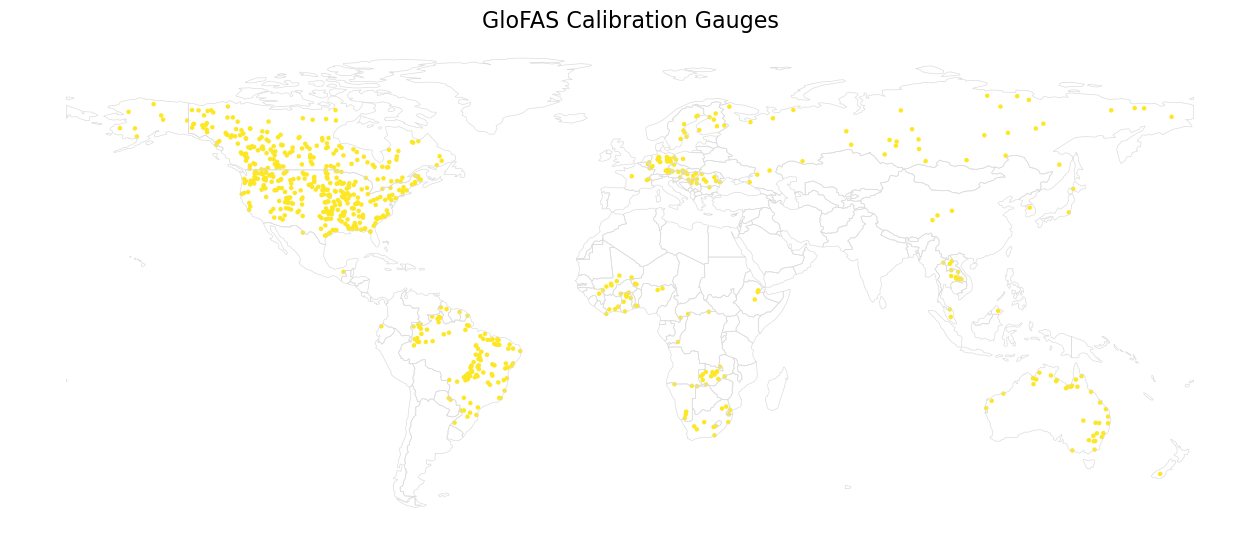

In [35]:
plotdata = [gauge for gauge in full_grdc_gauge_group if gauge in evaluation_gauges and gauge in glofas_grdc_gauge_group]
plotdata = pd.DataFrame(np.ones(len(plotdata)), index=plotdata)
plotdata.rename(columns={0: 'In GloFAS Calibration Set?'}, inplace=True)

evaluation_utils.spatial_plot(
  plotdata,
  latlon=attributes,
  metric='In GloFAS Calibration Set?',
  vmin=0,
  vmax=1,
  title='GloFAS Calibration Gauges',
  ms=5,
  colorbar=False
)
evaluation_utils.save_figure(data_paths.EVALUATION_GAUGE_LOCATIONS_MAP_FIGURE_FILENAME)